In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import timeit
import phgeograpy

In [21]:
DATASET_RAW_PATH = r"data\raw"
DATASET_INTERIM_PATH = r"data\interim"

In [3]:
df = pd.read_csv(os.path.join("..", DATASET_RAW_PATH, "Housing_v2.csv"))

In [4]:
df.head()

,Description,Location,Price,Bedrooms,Bathrooms,Floor Area,Land Area,Latitude,Longitude
0,Preselling 2-Storey Townhouses in Village East...,"Santo Domingo, Cainta",9500000.0,4.0,3.0,144.00,136.0,14.582341,121.118044
1,Affordable House & Lot with Complete Amenities...,"San Vicente, Santa Maria",4400000.0,3.0,2.0,63.20,80.0,14.807715,121.002402
2,5BR 2-Storey House and Lot for Sale in Tarlac ...,"Camella Tarlac Access Rd. Maliwalo, Tarlac",7810000.0,5.0,3.0,100.00,110.0,NaN,NaN
3,Maya Solo 3 Bedrooms Single Detached House for...,"Gabon, Abucay",NaN,3.0,2.0,67.00,88.0,14.717814,120.531325
4,Futura Homes Zamboanga | Amber 2BR Townhouse E...,"Zambowood Rd. Boalan, Zamboanga",3275000.0,2.0,1.0,40.32,78.4,6.948389,122.114889


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Description  1500 non-null   object 
 1   Location     1496 non-null   object 
 2   Price        1451 non-null   float64
 3   Bedrooms     1437 non-null   float64
 4   Bathrooms    1420 non-null   float64
 5   Floor Area   1463 non-null   float64
 6   Land Area    1477 non-null   float64
 7   Latitude     1211 non-null   float64
 8   Longitude    1211 non-null   float64
dtypes: float64(7), object(2)
memory usage: 105.6+ KB


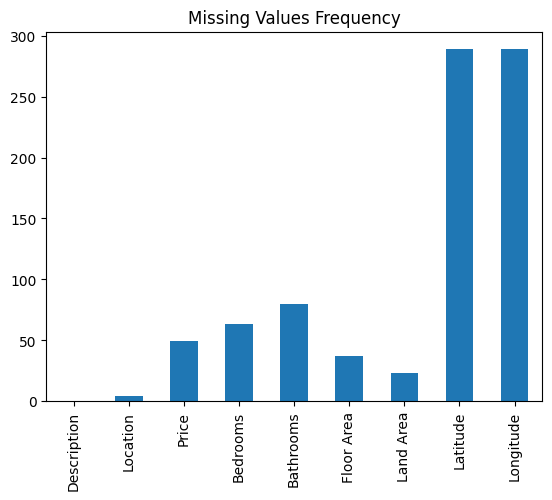

In [6]:
plt.title("Missing Values Frequency")
df.isnull().sum().plot(kind='bar')
plt.show()

Data Cleaning Procedures:
* Remove Description column as its values vary widely consisting of various characters.
* Remove Latitude and Longitude because there is already a Location columns which can be used as a categorical feature. Also, it contains a lot of missing values and the difference among the longitude and latitude of locations within the Philippines vary by a small magnitude which will make the locations seem near each other (which is true in global perspective, but not locally).
* If location data is a significant feature, remove rows with missing location because it will be required for predicting prices. Otherwise, simply drop the column.
* Remove rows with missing number of bedrooms and bathrooms.
* Remove rows with missing price values. It is the target values and must be not interpolated.
* Fill-in the missing values for Floor Area and Land Area columns with the mean or average of all the houses within their corresponding regions (Region column will be created).

In [117]:
df_copy = df.copy() # Create a copy

In [118]:
processed_data = df_copy.drop(['Latitude', 'Longitude'], axis=1) # Drop columns

In [119]:
# Drop rows with missing values in the specified columns
processed_data = processed_data.dropna(subset=['Price', 'Bedrooms', 'Bathrooms'])

In [120]:
processed_data.reset_index(drop=True, inplace=True) # reset index

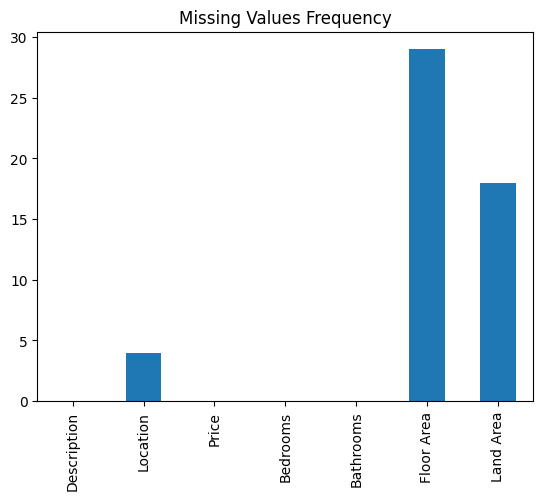

In [121]:
# Check for missing values
plt.title("Missing Values Frequency")
processed_data.isnull().sum().plot(kind='bar')
plt.show()

In [122]:
"""
- For each location, map a region by finding a match in one of its municipalities under its provinces.
"""

def map_region(x):

    x = x.lower()

    if ("pangasinan" in x) or ("iloilo" in x) or ("san fernando" in x):
        return "Region I"
    if ("tuguegarao" in x):
        return "Region II"
    if ("cavite" in x) or ("calamba" in x) or ("antipolo" in x) or ("tanauan" in x) or ("laguna" in x) or ("rizal" in x) or ("tagaytay" in x) or ("dasmariñas" in x) or ("carmona" in x) or ("san mateo" in x) or ("cainta" in x) or ("binan" in x):
        return "Region IV-A"
    if ("nueva ecija" in x) or ("bulacan" in x) or ("tarlac" in x) or ("zambales" in x) or ("pampanga" in x):
        return "Region III"
    if ("albay" in x):
        return "Region V"
    if ("kamuning" in x) or ("las pinas" in x) or ("bonifacio global city" in x) or ("bgc" in x) or ("pilar village" in x) or ("dasmarinas" in x) or ("paranaque" in x):
        return "NCR"
    if ("bacolod" in x):
        return "Region VI"
    if ("cebu" in x) or ("negros oriental" in x) or ("koronadal" in x):
        return "Region VII"
    if ("surigao del norte" in x):
        return "Region XIII"
    if ("davao" in x) or ("zamboanga" in x):
        return "Region XI"


    for region in phgeograpy.regions():
        if region.name == 'CAR':
            region.name = 'Region XIV'
        if region.name.lower() in x:
            # print(region.name, "|||", x)
            return region.name
        for province in phgeograpy.regions(region.slug).provinces():
            if province.name.lower() in x:
                # print(region.name, province.name, "|||", x)
                return region.name
            for municipality in phgeograpy.regions(region.slug).provinces(province.slug).municipalities():
                if municipality.name.lower() in x:
                    # print(region.name, province.name, municipality.name, "|||", x)
                    return region.name
    

    return None

In [123]:
# Determining the region based on the given description
processed_data['Region'] = processed_data['Description'].apply(map_region)

In [124]:
# Determining the regions of the resulting dataframe with no regions using the Location column
processed_data.loc[processed_data['Region'].isna(), 'Region'] = processed_data[processed_data['Region'].isna()]['Location'].map(map_region)

In [127]:
int(processed_data['Region'].isna().sum()) # There are no more rows with missing region

0

In [129]:
# Save data with regions as an interim data
processed_data.to_csv(os.path.join("..", DATASET_INTERIM_PATH, "with_regions.csv"), index=False)